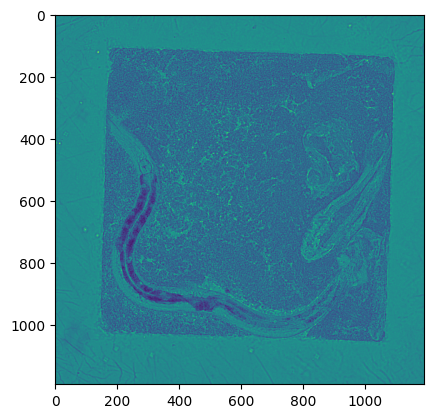

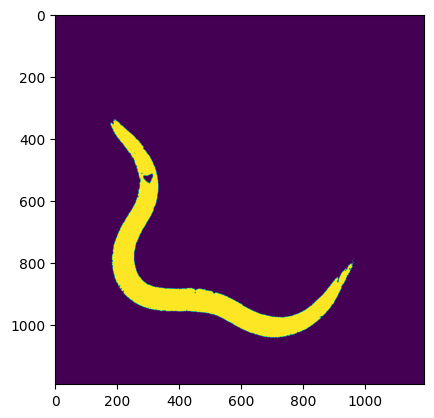

In [1]:
import os 
from pytorch_toolbelt import inference
from towbintools.foundation import image_handling
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

image_dir = "/mnt/external.data/TowbinLab/plenart/20221020_Ti2_10x_green_bacteria_wbt150_small_chambers_good/raw/"
images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".tiff")]

test_image_path = images[69094]
test_image = image_handling.read_tiff_file(test_image_path, [2])

test_ground_truth = image_handling.read_tiff_file(test_image_path, [1])
thresh_otsu = threshold_otsu(test_ground_truth)
test_ground_truth = (test_ground_truth > thresh_otsu).astype('uint8')

plt.imshow(test_image)
plt.show()

plt.imshow(test_ground_truth)
plt.show()

In [2]:
image_slicer = inference.ImageSlicer(test_image.shape, (512, 512), (256, 256))

tiles = image_slicer.split(test_image)
tiles = tiles
tiles_ground_truth = image_slicer.split(test_ground_truth)
tiles_ground_truth = tiles_ground_truth

In [3]:
from unet import UNet
import torch
import numpy as np
from pytorch_toolbelt.losses.focal import BinaryFocalLoss
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchvision.transforms import ToTensor
import lightning.pytorch as pl

class LightningUNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet(n_channels=1, n_classes=1, bilinear=True)
        self.model = self.model.double()
        self.criterion = BinaryFocalLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = BinaryFocalLoss()(y_hat, y)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

class TilesDataset(Dataset):
    def __init__(self, tiles, ground_truth_tiles):
        self.tiles = tiles
        self.ground_truth_tiles = ground_truth_tiles

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, i):

        img = self.tiles[i]
        img = img/np.max(img)
        img = img[np.newaxis, ...]
        mask = self.ground_truth_tiles[i]
        mask = mask[np.newaxis, ...].astype(np.float64)
        
        return torch.tensor(img), torch.tensor(mask)

model = LightningUNet().load_from_checkpoint("/home/spsalmon/towbintools/towbintools/deep_learning/unet_lightning_test/epoch=3-step=668.ckpt", map_location=torch.device('cpu'))

image max 5.821743255874332, image min -4.233601215033144


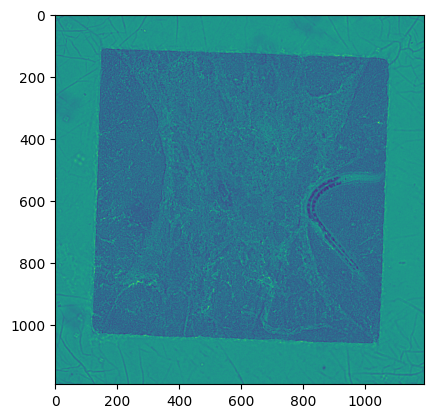

image max 4.2770304988219765, image min -4.461630241074206


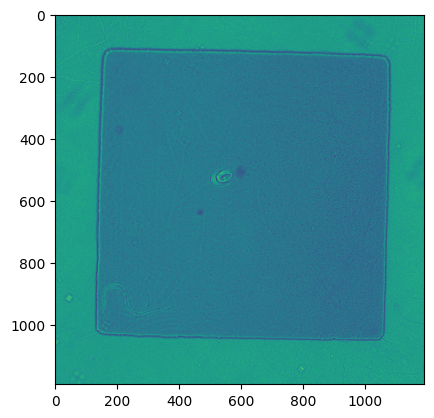

image max 6.108618482184055, image min -4.5425437664436155


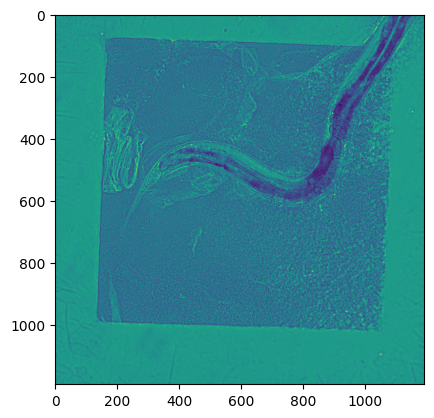

image max 5.873233681109411, image min -4.27773586523464


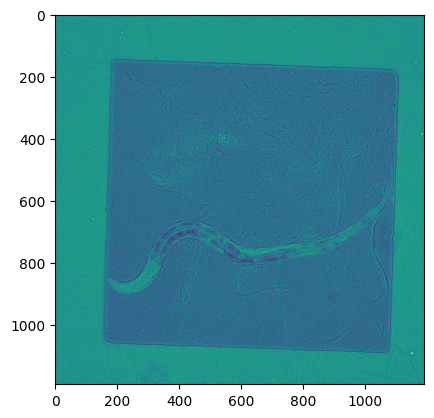

image max 6.910397960844564, image min -4.093841489395074


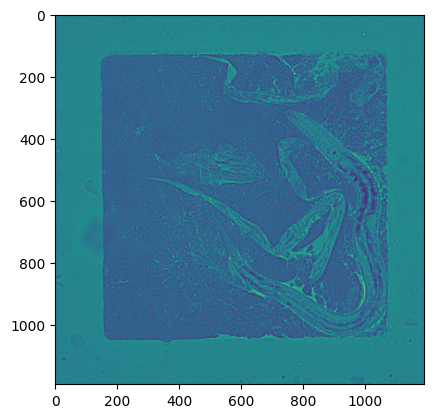

image max 6.167464682452716, image min -4.02763951409283


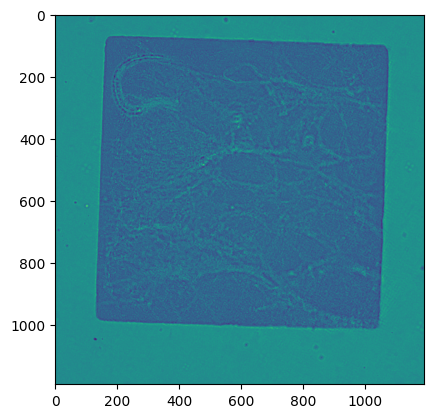

image max 5.549579579631774, image min -3.6892738625480286


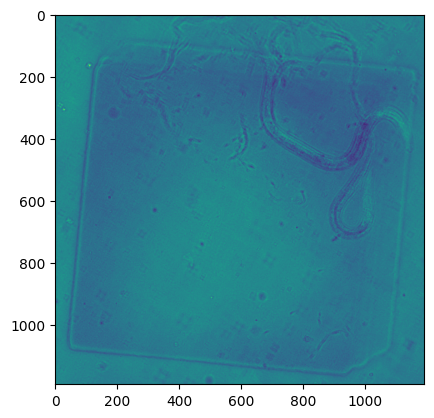

image max 5.9173683313109064, image min -4.5204764413428675


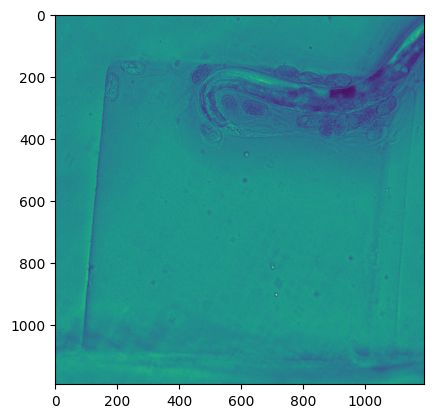

image max 6.903042185810981, image min -4.564611091544363


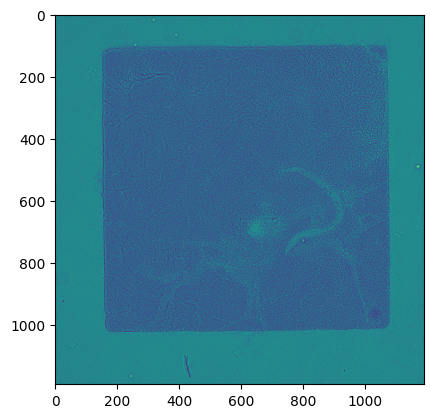

image max 5.328906328624295, image min -4.373360940671215


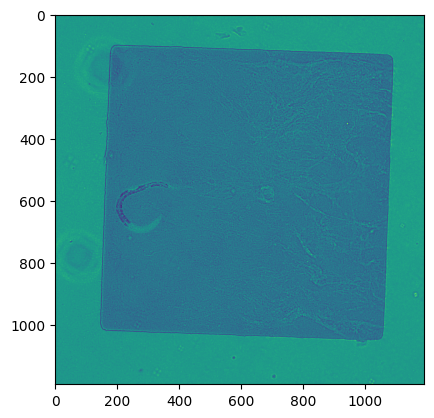

image max 6.086551157083307, image min -4.5425437664436155


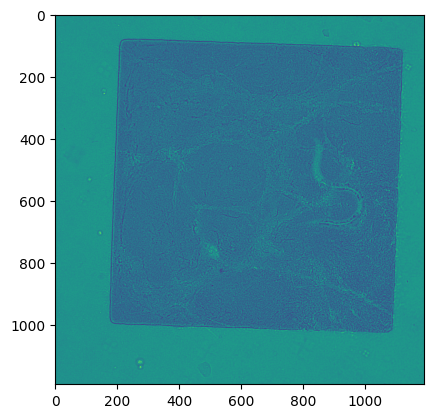

image max 6.7044362599042495, image min -4.608745741745859


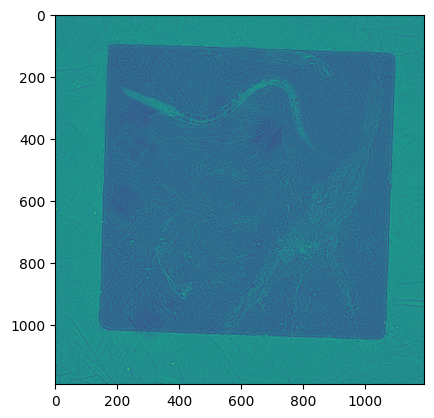

image max 5.807031705807167, image min -4.233601215033144


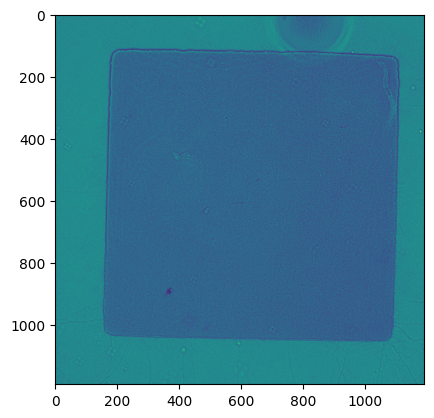

image max 5.858522131042245, image min -4.424851365906293


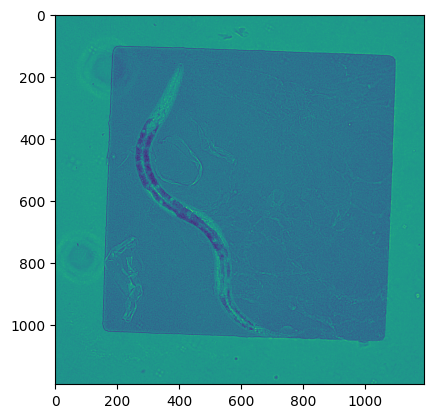

image max 5.623137329967601, image min -4.932399843223496


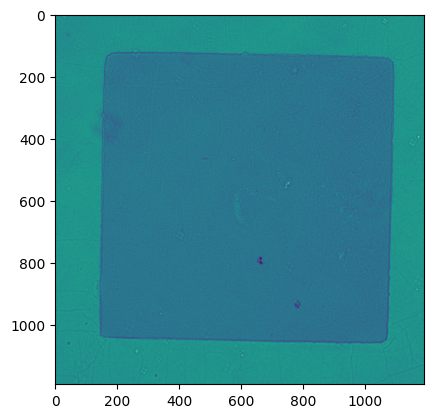

image max 6.5793880843333445, image min -4.079129939327909


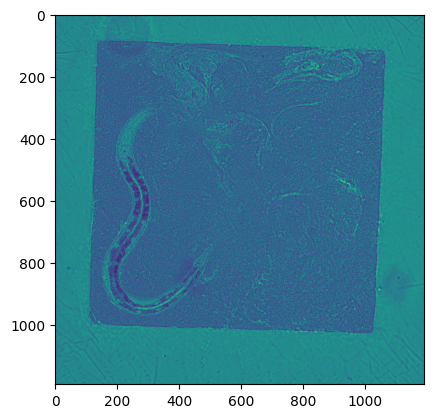

image max 7.035446136415469, image min -4.961822943357826


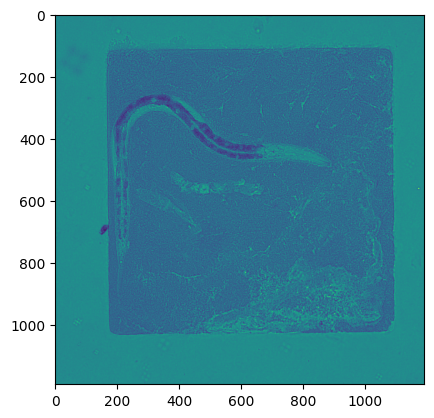

image max 4.880204051575753, image min -3.534802586842793


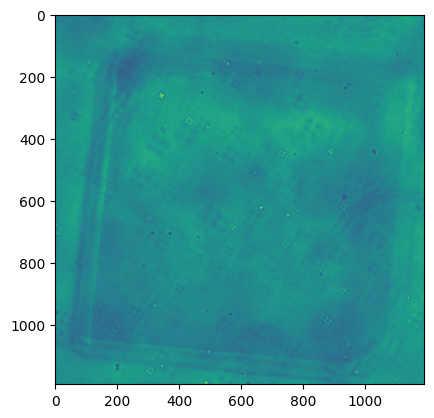

image max 4.321165149023472, image min -4.402784040805545


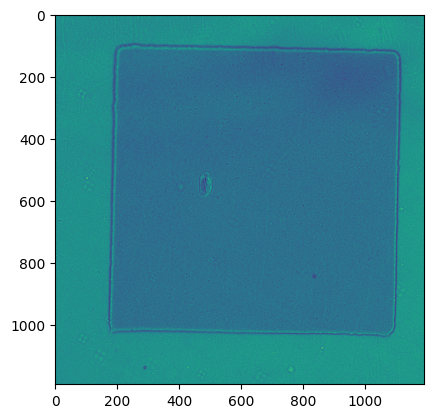

image max 5.608425779900435, image min -4.476341791141372


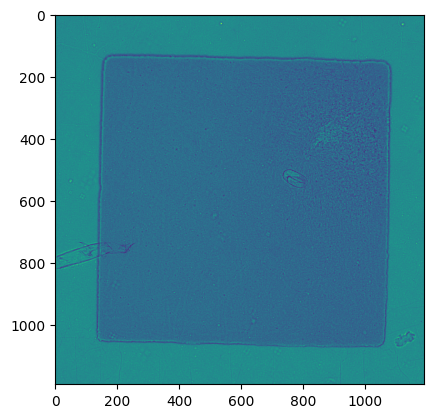

image max 6.888330635743816, image min -4.336582065503301


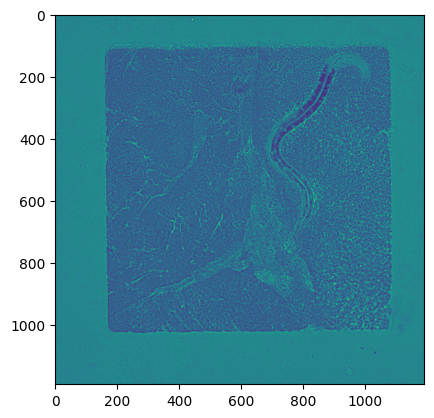

image max 6.59409963440051, image min -4.733793917316764


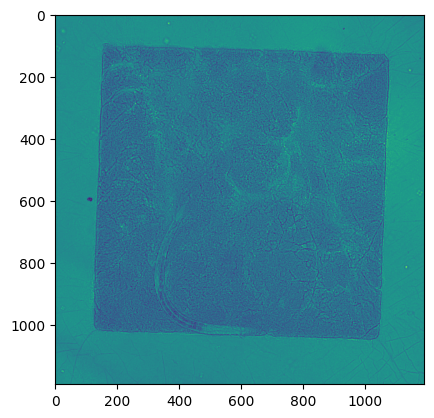

image max 6.608811184467675, image min -4.299803190335388


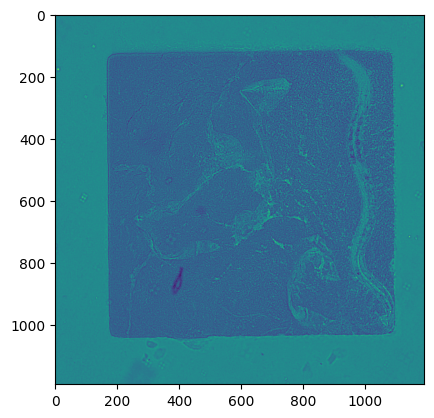

image max 7.73424476460582, image min -4.513120666309285


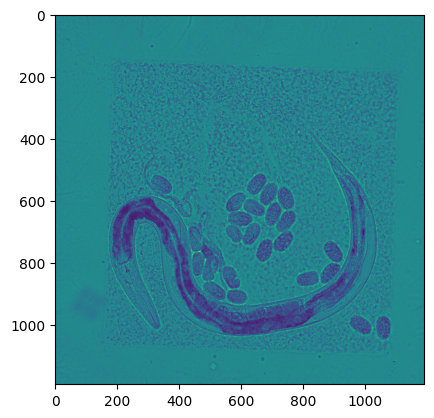

image max 6.263089757889291, image min -5.359034795171289


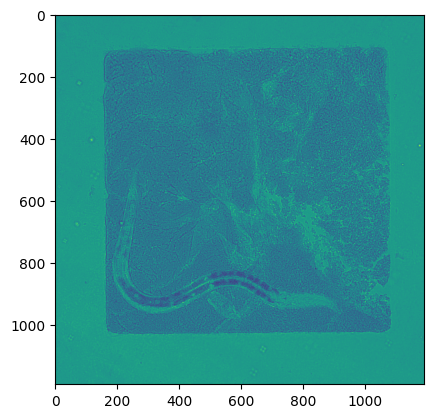

image max 7.131071211852043, image min -4.270380090201058


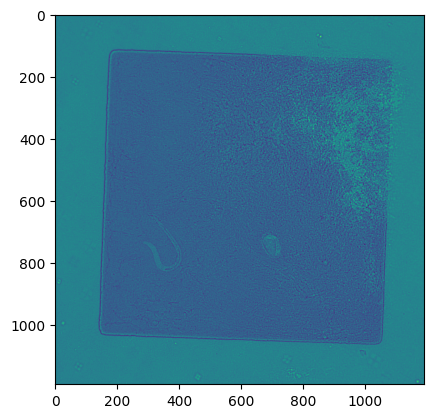

image max 5.9982818566803155, image min -4.3145147404025534


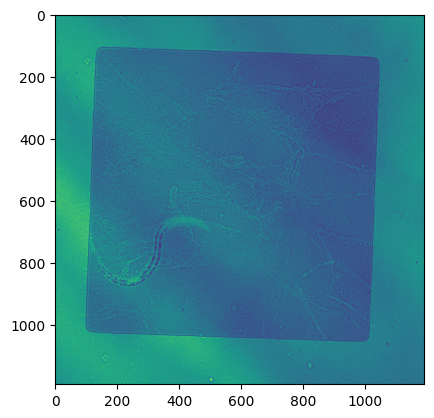

image max 6.711792034937832, image min -4.233601215033144


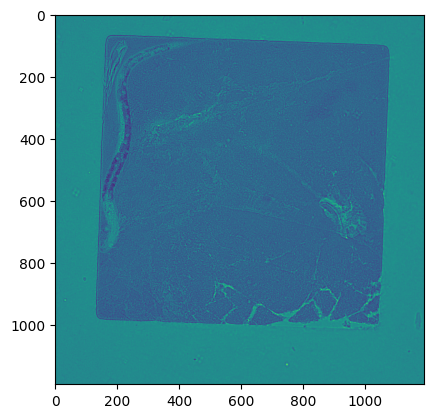

image max 5.328906328624295, image min -4.182110789798066


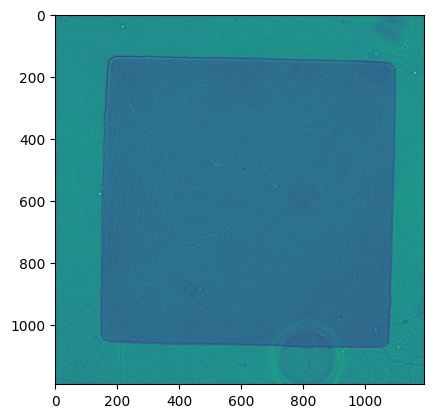

image max 3.0412602931800925, image min -4.557255316510781


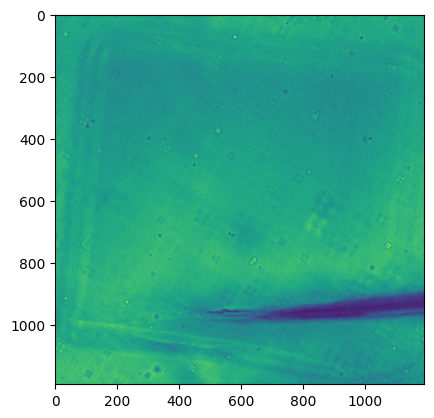

In [4]:
image_dir = "/mnt/external.data/TowbinLab/plenart/20221020_Ti2_10x_green_bacteria_wbt150_small_chambers_good/raw/"
images = [os.path.join(image_dir, f)
					   for f in os.listdir(image_dir) if f.endswith(".tiff")]

train_images_path = images[69060:69090]
val_images_path = images[69090:69100]

training_tiles = []
training_ground_truth_tiles = []

validation_tiles = []
validation_ground_truth_tiles = []

mean_train_images = []
std_train_images = []

for image_path in train_images_path:
	image = image_handling.read_tiff_file(image_path, [2])
	mean_train_images.append(image.mean())
	std_train_images.append(image.std())

mean_train_images = np.array(mean_train_images)
std_train_images = np.array(std_train_images)

mean_train = mean_train_images.mean()
std_train = std_train_images.mean()

for image_path in train_images_path:
	image = image_handling.read_tiff_file(image_path, [2])

	image = (image - mean_train) / std_train

	print(f'image max {image.max()}, image min {image.min()}')
	plt.imshow(image)
	plt.show()

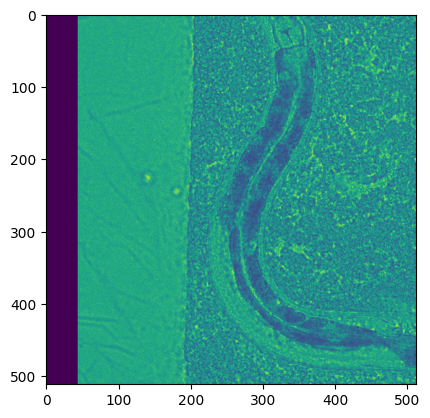

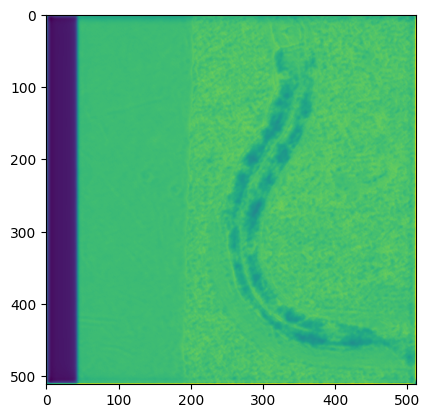

In [6]:
model.eval()
with torch.no_grad():

    test_tile = tiles[8]
    test_tile = test_tile/np.max(test_tile)

    plt.imshow(test_tile.squeeze())
    plt.show()

    test_tile = test_tile[np.newaxis, np.newaxis, ...]
    test_tile = torch.tensor(test_tile)

    pred = model(test_tile)
    # pred = torch.sigmoid(pred) > 0.4
    pred = pred.squeeze().numpy()

    plt.imshow(pred.squeeze())
    plt.show()